In [1]:
'''
author: EdgardoCS @FSU Jena
date: 18.06.2025
'''

# install openpyxl

import bambi as bmb
import arviz as az
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.genmod as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from textwrap import wrap

In [2]:
input_data = 'output/data_sorted.xlsx'
columns = ['Id', 'Rating', 'Gender', 'Segment', 'Location', 'Type']

data = pd.read_excel(input_data, usecols=columns)

# focus on Female and Male for now
data = (data[data['Gender'].isin(['Female', 'Male'])])

In [3]:
# Define all factor levels
c1 = ['Self', 'Other']
c2 = ['Front', 'Back']
c3 = ['Armpits', 'Chest', 'Feet', 'Hair', 'Hands', 'Legs', 'Mouth', 'Neck', 'Pelvis']
c4 = ['Male', 'Female']

In [4]:
# Build full grid for each subject × all combinations of the 4 factors
all_combos = pd.DataFrame([
    (i, g, t, l, s)
    for i in data['Id'].unique()
    for g, t, l, s in itertools.product(c4, c1, c2, c3)
], columns=['Id', 'Gender', 'Type', 'Location', 'Segment'])

# Add indicator of whether that combination was rated
data['Marked'] = (data['Rating'] > 0).astype(int)

# Merge data with all possible combinations
merged = all_combos.merge(
    data[['Id', 'Gender', 'Type', 'Location', 'Segment', 'Marked']],
    on=['Id', 'Gender', 'Type', 'Location', 'Segment'],
    how='left'
)

# Fill missing with 0 = not marked
merged['Marked'] = merged['Marked'].fillna(0).astype(int)

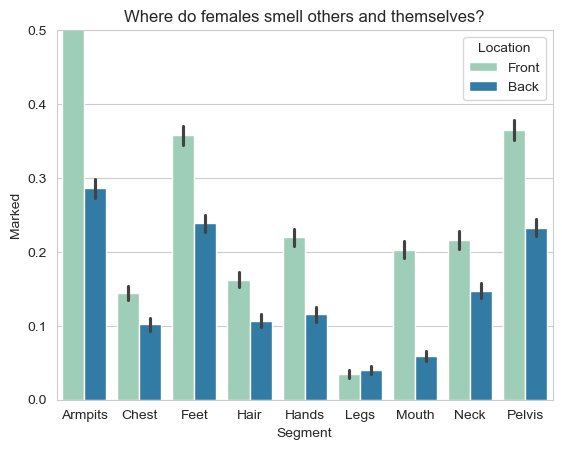

Text(0.5, 1.0, 'Where do males smell others and themselves?')

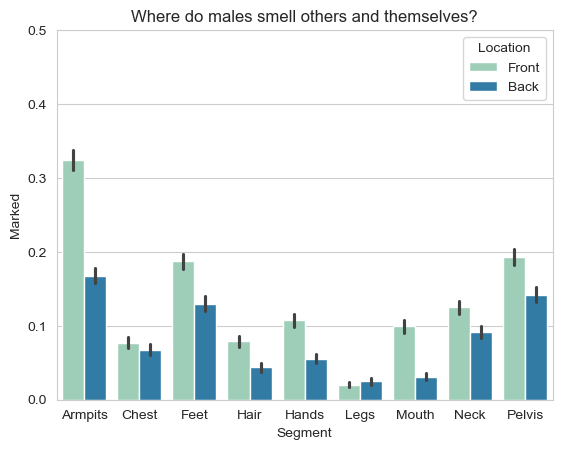

In [5]:
female = merged[merged['Gender'] == 'Female'].copy()
male = merged[merged['Gender'] == 'Male'].copy()

sns.barplot(
    data=female,
    hue="Location",
    x="Segment",
    y="Marked",
    palette='YlGnBu'
)
plt.ylim(0, 0.5)
plt.title('Where do females smell others and themselves?')

plt.show()
sns.barplot(
    data=male,
    hue="Location",
    x="Segment",
    y="Marked",
    palette='YlGnBu'
)
plt.ylim(0, 0.5)
plt.title('Where do males smell others and themselves?')

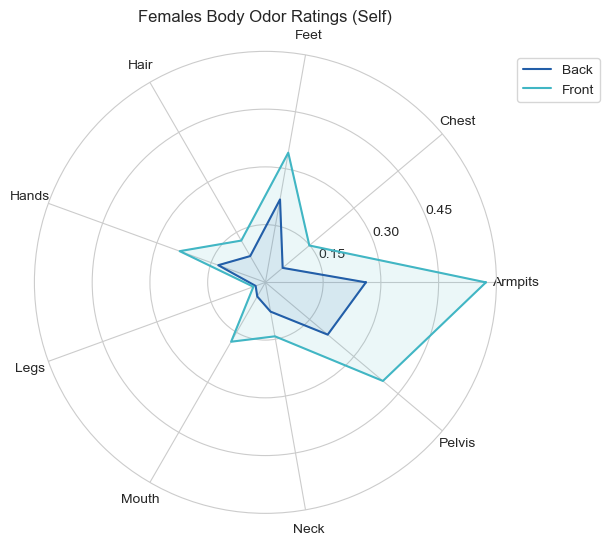

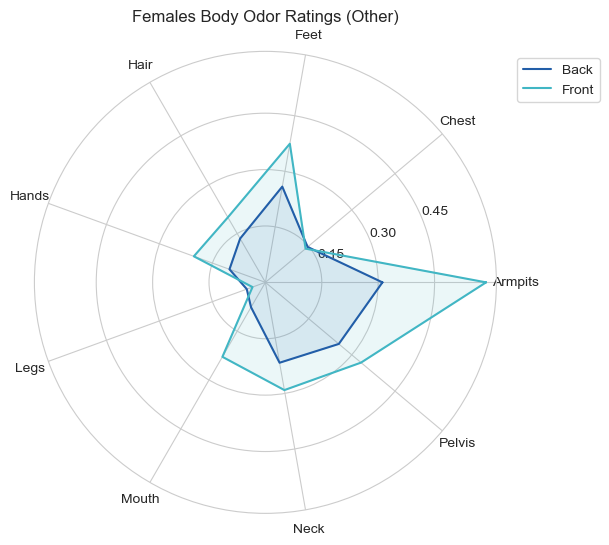

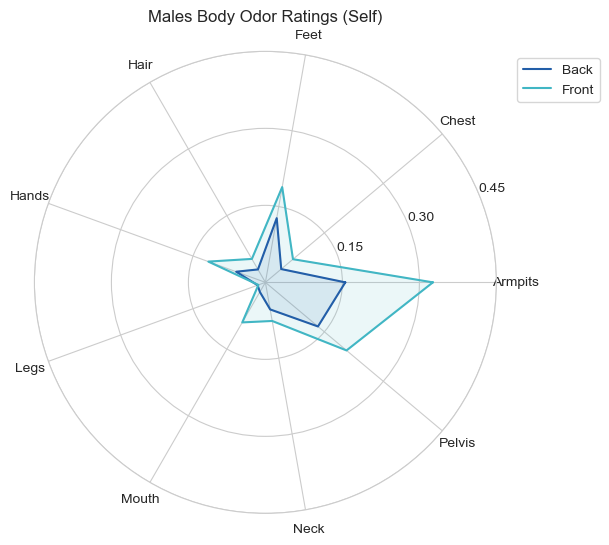

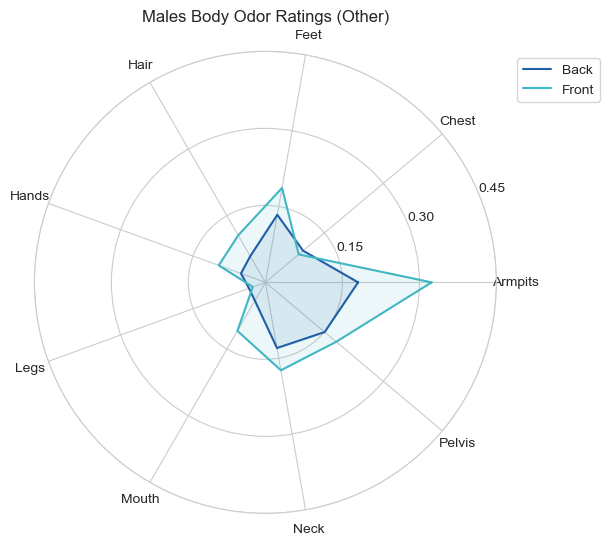

In [7]:
types = ['Self', 'Other']
colors = ['#41b6c4', '#225ea8']

grouped = female.groupby(['Segment', 'Location', 'Type'])['Marked']
estimates = grouped.mean().reset_index()
estimates = estimates.rename(columns={'Marked': 'Mean_Marked'})

for i, t in enumerate(types):
    pivot_df = estimates[estimates['Type'] == t].pivot(
        index='Location',
        columns='Segment',
        values='Mean_Marked'
    )
    categories = list(pivot_df.columns)
    N = len(categories)

    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for idx, row in pivot_df.iterrows():
        values = row.tolist()
        values += values[:1]
        if idx == "Front":
            ax.plot(angles, values, label=idx, color=colors[0])
            ax.fill(angles, values, alpha=0.1, color=colors[0])
        elif idx == "Back":
            ax.plot(angles, values, label=idx, color=colors[1])
            ax.fill(angles, values, alpha=0.1, color=colors[1])

    ticks = [0.15, 0.30, 0.45]

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_yticks(ticks)
    ax.set_title(f'Females Body Odor Ratings ({t})')
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
    plt.savefig('output/radar-female-' + t + '.png', dpi=350, bbox_inches='tight')
    plt.show()

grouped = male.groupby(['Segment', 'Location', 'Type'])['Marked']
estimates = grouped.mean().reset_index()
estimates = estimates.rename(columns={'Marked': 'Mean_Marked'})

for i, t in enumerate(types):
    pivot_df = estimates[estimates['Type'] == t].pivot(
        index='Location',
        columns='Segment',
        values='Mean_Marked'
    )
    categories = list(pivot_df.columns)
    N = len(categories)

    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for idx, row in pivot_df.iterrows():
        values = row.tolist()
        values += values[:1]
        if idx == "Front":
            ax.plot(angles, values, label=idx, color=colors[0])
            ax.fill(angles, values, alpha=0.1, color=colors[0])
        elif idx == "Back":
            ax.plot(angles, values, label=idx, color=colors[1])
            ax.fill(angles, values, alpha=0.1, color=colors[1])

    ticks = [0.15, 0.30, 0.45]

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_yticks(ticks)
    ax.set_title(f'Males Body Odor Ratings ({t})')
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
    plt.savefig('output/radar-male-' + t + '.png', dpi=350, bbox_inches='tight')
    plt.show()

In [8]:
# Logistic mixed-effects model
model = smf.glm(
    "Marked ~ Segment * Gender * Location * Type",
    data=merged,
    family=sm.families.Binomial()
)
result = model.fit()
print(result.summary())

# Reference: Female, Others, armpit
# Intercept -0,7939, p < 0.001  (***)

# Location (front)  1,145,  p < 0.001 (***)
# Type (Self)       -0,246, p < 0.001 (***)
# Gender (Male)     -0,718, p < 0.001 (***)
# β, p
# Segment[T.chest]  -0,9682,    p < 0.001 (***)
# Segment[T.feet]   -0,2593,    p < 0.001(***)
# Segment[T.hair]   -1,0679,    p < 0.001 (***)
# Segment[T.hand]   -1,3846,    p < 0.001 (***)
# Segment[T.legs]   -2,0947,    p < 0.001 (***)
# Segment[T.mouth]  -1,6987,    p < 0.001 (***)
# Segment[T.neck]   -0,4887,    p < 0.001(***)
# Segment[T.pelvis] -0,2789,    p < 0.001 (***)

# Compared to the highest rated Segment, armpit, the rest of the segments were rated significantly lower with the exception of the feet.
# All segments were rated significantly higher in front
# There is a four-way interaction for type (self, other)(p < 0.001), gender(female, male)(p < 0.001), and location(front, back)(p < 0.001) for ratings of body segments.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Marked   No. Observations:               173448
Model:                            GLM   Df Residuals:                   173376
Model Family:                Binomial   Df Model:                           71
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -66101.
Date:                Fri, 20 Jun 2025   Deviance:                   1.3220e+05
Time:                        15:31:04   Pearson chi2:                 1.73e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.09603
Covariance Type:            nonrobust                                         
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

In [9]:
# 1. Is there any difference between Female and Male when smelling Others?
target = (merged[
              (merged['Type'] == 'Other') &
              (merged['Gender'].isin(['Female', 'Male']))]
          .copy())
# same model, only for type others
model = smf.mixedlm(
    "Marked ~ Segment * Location * Gender",
    merged,
    groups=merged["Id"]
)
result1 = model.fit()

print(result1.summary())

C:\Users\silva\AppData\Local\anaconda3\envs\bodyOdors\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                            Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             Marked     
No. Observations:              173448              Method:                         REML       
No. Groups:                    2409                Scale:                          0.1136     
Min. group size:               72                  Log-Likelihood:                 -59127.7138
Max. group size:               72                  Converged:                      Yes        
Mean group size:               72.0                                                           
----------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                           0.286    0.005  56.935 0.00

In [11]:
check = pd.crosstab([merged['Segment'], merged['Location']], merged['Marked'])
print(check)

Marked               0     1
Segment Location            
Armpits Back      7447  2189
        Front     5276  4360
Chest   Back      8814   822
        Front     8568  1068
Feet    Back      7858  1778
        Front     7006  2630
Hair    Back      8910   726
        Front     8471  1165
Hands   Back      8809   827
        Front     8059  1577
Legs    Back      9323   313
        Front     9370   266
Mouth   Back      9199   437
        Front     8176  1460
Neck    Back      8485  1151
        Front     7989  1647
Pelvis  Back      7828  1808
        Front     6945  2691


In [12]:
# 1. Is there any difference between Female and Male when smelling Others?
target = (merged[
              (merged['Type'] == 'Other') &
              (merged['Gender'].isin(['Female', 'Male']))]
          .copy())
model = bmb.Model("Marked ~ Segment * Location * Gender", data=target, family="bernoulli")

# Fit with NUTS sampling (MCMC)
result1 = model.fit(draws=2000, chains=4)
summary_df = az.summary(result1)

Modeling the probability that Marked==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Segment, Location, Segment:Location, Gender, Segment:Gender, Location:Gender, Segment:Location:Gender]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 830 seconds.


In [61]:
# summary_df = az.summary(results)

# Since this is a logistic model, coefficients are in log-odds.
# positive mean == more likely; negative mean == less likely
intercept_mean = summary_df.loc['Intercept', 'mean']

segments = ['Armpits', 'Chest', 'Feet', 'Hair', 'Hands', 'Legs', 'Mouth', 'Neck', 'Pelvis']

In [62]:
gender_others = pd.DataFrame(columns=['Segment', 'Interaction', 'Log odds', 'Odds Ratio (exp(Δ))', '%'])
# -----------------------------------------------------------------------------------------------------------------#
gender_mean = summary_df.loc['Gender[Male]', 'mean']
# Compare data, Gender
for segment in segments:
    try:
        a = (gender_mean
             + summary_df.loc['Segment:Gender[' + segment + ', Male]', ['mean']])
        b = np.exp(a)
        c = b - 1
        new_row = {
            "Segment": segment,
            "Interaction": summary_df.loc['Segment:Gender[' + segment + ', Male]']['mean'],
            "Log odds": a['mean'],
            'Odds Ratio (exp(Δ))': b['mean'],
            '%': c['mean'] * 100
        }
        gender_others = pd.concat([gender_others, pd.DataFrame([new_row])], ignore_index=True)

    except KeyError as err:
        a = (gender_mean
             + intercept_mean)
        b = np.exp(a)
        c = b - 1
        new_row = {
            "Segment": segment,
            "Interaction": '-',
            "Log odds": a,
            'Odds Ratio (exp(Δ))': b,
            '%': c * 100
        }
        gender_others = pd.concat([gender_others, pd.DataFrame([new_row])], ignore_index=True)
print(gender_others)

   Segment Interaction  Log odds  Odds Ratio (exp(Δ))          %
0  Armpits           -    -1.516             0.219588 -78.041151
1    Chest       0.241    -0.481             0.618165 -38.183508
2     Feet      -0.093    -0.815             0.442639 -55.736067
3     Hair      -0.182    -0.904             0.404947 -59.505337
4    Hands      -0.034    -0.756             0.469541 -53.045916
5     Legs       0.262    -0.460             0.631284 -36.871635
6    Mouth       0.053    -0.669             0.512221 -48.777946
7     Neck       0.104    -0.618             0.539021 -46.097860
8   Pelvis       0.066    -0.656             0.518923 -48.107712


C:\Users\silva\AppData\Local\Temp\ipykernel_24672\3875196368.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gender_others = pd.concat([gender_others, pd.DataFrame([new_row])], ignore_index=True)


In [ ]:
female_location_others = pd.DataFrame(columns=['Segment', 'Interaction', 'Log odds', 'Odds Ratio (exp(Δ))', '%'])
# -----------------------------------------------------------------------------------------------------------------#
# Compare data, females, Location
location_mean = summary_df.loc['Location[Front]', 'mean']
for segment in segments:
    try:
        a = (location_mean
             + summary_df.loc['Segment:Location[' + segment + ', Front]', ['mean']])
        b = np.exp(a)
        c = b - 1
        new_row = {
            "Segment": segment,
            "Interaction": summary_df.loc['Segment:Location[' + segment + ', Front]']['mean'],
            "Log odds": a['mean'],
            'Odds Ratio (exp(Δ))': b['mean'],
            '%': c['mean'] * 100
        }
        female_location_others = pd.concat([female_location_others, pd.DataFrame([new_row])], ignore_index=True)

    except KeyError as err:
        a = (location_mean
             + intercept_mean)
        b = np.exp(a)
        c = b - 1
        new_row = {
            "Segment": segment,
            "Interaction": '-',
            "Log odds": a,
            'Odds Ratio (exp(Δ))': b,
            '%': c * 100
        }
        female_location_others = pd.concat([female_location_others, pd.DataFrame([new_row])], ignore_index=True)
print(female_location_others)

In [68]:
# Example of analyisis
#
# Mouth	+256.1%	This is the most preferred segment when shown at the front. The odds of the mouth being selected are more than 3.5 times higher when presented at the front vs. the back.
# Hands	+124.3%	Very strong preference for viewing hands from the front. This suggests a strong front-dominant perception or importance.
# Feet	+72.1%	Moderately strong front-view preference, possibly due to greater visibility or expressiveness when seen from the front.
# Hair	+61.3%	Clear preference for frontal presentation — possibly due to face-framing hairstyles or symmetry.
# Neck	+48.4%	Shows notable preference — frontal views may emphasize posture, accessories, or grooming.
# Pelvis	+45.8%	The front may convey more informative or expressive cues (e.g., clothing details, body posture).


In [64]:
male_location_others = pd.DataFrame(columns=['Segment', 'Interaction', 'Log odds', 'Odds Ratio (exp(Δ))', '%'])
# -----------------------------------------------------------------------------------------------------------------#
# Compare data, male, Location
for segment in segments:
    try:
        a = (summary_df.loc['Location:Gender[Front, Male]', 'mean']
             + summary_df.loc['Segment:Location:Gender[' + segment + ', Front, Male]', ['mean']])
        b = np.exp(a)
        c = b - 1
        new_row = {
            "Segment": segment,
            "Interaction": summary_df.loc['Segment:Location:Gender[' + segment + ', Front, Male]']['mean'],
            "Log odds": a['mean'],
            'Odds Ratio (exp(Δ))': b['mean'],
            '%': c['mean'] * 100
        }
        male_location_others = pd.concat([male_location_others, pd.DataFrame([new_row])], ignore_index=True)

    except KeyError as err:
        a = (summary_df.loc['Location:Gender[Front, Male]', 'mean']
             + intercept_mean)
        b = np.exp(a)
        c = b - 1
        new_row = {
            "Segment": segment,
            "Interaction": '-',
            "Log odds": a,
            'Odds Ratio (exp(Δ))': b,
            '%': c * 100
        }
        male_location_others = pd.concat([male_location_others, pd.DataFrame([new_row])], ignore_index=True)
print(male_location_others)

   Segment Interaction  Log odds  Odds Ratio (exp(Δ))          %
0  Armpits           -    -1.141             0.319499 -68.050064
1    Chest       0.261    -0.086             0.917594  -8.240577
2     Feet       0.201    -0.146             0.864158 -13.584230
3     Hair       0.499     0.152             1.164160  16.416024
4    Hands       0.235    -0.112             0.894044 -10.595574
5     Legs       0.428     0.081             1.084371   8.437090
6    Mouth       0.131    -0.216             0.805735 -19.426470
7     Neck       0.295    -0.052             0.949329  -5.067113
8   Pelvis       0.183    -0.164             0.848742 -15.125798


C:\Users\silva\AppData\Local\Temp\ipykernel_24672\1643448350.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  male_location_others = pd.concat([male_location_others, pd.DataFrame([new_row])], ignore_index=True)


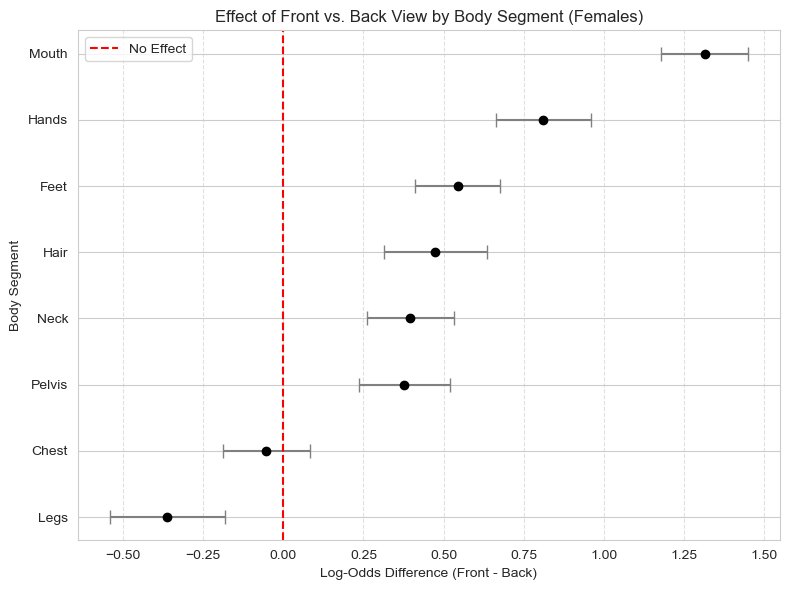

In [69]:
data = pd.DataFrame({
    'Segment': ['Mouth', 'Hands', 'Feet', 'Hair', 'Neck', 'Pelvis', 'Chest', 'Legs'],
    'Effect': [1.314, 0.81, 0.544, 0.474, 0.396, 0.377, -0.053, -0.362],
    'Lower_CI': [1.179, 0.662, 0.412, 0.313, 0.261, 0.235, -0.188, -0.541],
    'Upper_CI': [1.449, 0.958, 0.676, 0.635, 0.531, 0.519, 0.082, -0.183]
})

# Sort by effect
data = data.sort_values('Effect')

plt.figure(figsize=(8, 6))
plt.errorbar(data['Effect'], data['Segment'],
             xerr=[data['Effect'] - data['Lower_CI'], data['Upper_CI'] - data['Effect']],
             fmt='o', color='black', ecolor='gray', capsize=5)
plt.axvline(0, color='red', linestyle='--', label='No Effect')
plt.title('Effect of Front vs. Back View by Body Segment (Females)')
plt.xlabel('Log-Odds Difference (Front - Back)')
plt.ylabel('Body Segment')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend()
plt.show()

In [66]:
# az.plot_forest(results, kind="forestplot", combined=True)
# az.plot_trace(results)
# az.plot_posterior(results)